<a href="https://colab.research.google.com/github/menasiraziz/Convnet/blob/work/convnet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

In [0]:
from numpy.lib.stride_tricks import as_strided


def strided_convolution3D(image, weight, stride):
    m,ch,im_h, im_w = image.shape
    f,t,f_h, f_w = weight.shape
    out_shape = (m,ch,1 + (im_h - f_h) // stride, 1 + (im_w - f_w) // stride, f_h, f_w)
    out_strides = (image.strides[0],image.strides[1],image.strides[2] * stride, image.strides[3] * stride, image.strides[2], image.strides[3])
    windows = as_strided(image, shape=out_shape, strides=out_strides)
    return np.einsum('mcopjk,ecjk->meop',windows,weight)

def mx_pool(img,s): # function takes advatange of row order of numpy array
  m,ch,n,n=img.shape # flatten all images into stride 
  c=img.reshape(-1,s) #change s to change horizontal stride
  ind=np.argmax(c,axis=1)
  ind1=np.ravel_multi_index([np.arange(ind.shape[0]),ind], (ind.shape[0],s))
  d=img.flatten()[ind1]
  g=d.reshape(-1,s,int(n/s)) #probably i need to change s in the middle to change vertical stride

  h=g.argmax(axis=1)
  i1=np.arange(g.shape[0]) # varies along images in data 
  i2=np.arange(g.shape[2]) # varies along col axis in indices
  ss=i1[:,np.newaxis]*n+g.shape[2]*h+i2 # i2 is varying along col and i1 is varying along batch and row dim
  return ind1[ss.flatten()]


import numpy as np
from numpy.lib.stride_tricks import as_strided


def strided_convolution3D1_g(image, weight, stride):
    m,ch,im_h, im_w = image.shape
    f,t,f_h, f_w = weight.shape
    #print(m)
    out_shape = (m,ch,1 + (im_h - f_h) // stride, 1 + (im_w - f_w) // stride, f_h, f_w)
    out_strides = (image.strides[0],image.strides[1],image.strides[2] * stride, image.strides[3] * stride, image.strides[2], image.strides[3])
    windows = as_strided(image, shape=out_shape, strides=out_strides)
    #print(windows.shape)
    #print(windows)
    return np.einsum('meopjk,ecjk->mecop',windows,weight)
    #return np.einsum('meopjk,ecjk->meop',windows,weight)
    #return np.einsum('meopjk,ecjk->mecop',windows,weight)

def strided_convolution3D_grad1(image, weight, stride):
    m,ch,im_h, im_w = image.shape
    m1,m2,f_h, f_w = weight.shape
    
    #print(m)
    out_shape = (m,ch,1 + (im_h - f_h) // stride, 1 + (im_w - f_w) // stride, f_h, f_w)
    out_strides = (image.strides[0],image.strides[1],image.strides[2] * stride, image.strides[3] * stride, image.strides[2], image.strides[3])
    windows = as_strided(image, shape=out_shape, strides=out_strides)
    #print(windows.shape)
    #print(windows[0])
    #print(windows*gg1)
    return np.einsum('mcopjk,mejk->mecop',windows,weight)


In [0]:
class ConvLayer:
  def __init__(self,in_ch=1,out_ch=1,kernel=(2,2),stride=1):
    self.filters=np.random.randn(out_ch,in_ch,kernel[0],kernel[1])
    self.stride=stride

  def feedforward(self,x):
    if(x.shape[1]!=self.filters.shape[1]):
      print(x.shape[1])
      print(self.filters.shape[1])
      raise Exception("channels in input and output are not same")
    self.out=strided_convolution3D(x,self.filters,self.stride)
    return self.out
  def grad(self,x,loss_grad):
    self.df=strided_convolution3D_grad1(x,loss_grad,1).sum(axis=0)
    gg=np.rot90(loss_grad,2,axes=(2,3))
    gg1=np.pad(gg, ((0, 0),(0, 0),(1, 1),(1,1)), 'constant', constant_values=(0))
    ooo=strided_convolution3D1_g(gg1,self.filters,1)
    return np.rot90(ooo,2,axes=(3,4)).sum(axis=1)

class FC_Layer:
  def __init__(self,i_dim,out_dim):
    self.W=np.random.randn(i_dim,out_dim)
    self.dw=np.zeros(self.W.shape)
  def feedforward(self,x):
    self.out=np.dot(x,self.W)
    return self.out
  def grad(self,x,loss_grad):
    return self.W*loss_grad[:,np.newaxis]

class Network:
  def __init__(self):
    self.n=7
    self.in_ch=1
    self.m=4
    self.f1=2
    self.f2=2
    self.cs=1
    self.o_ch=1

    self.mxs=2

    self.conv1=ConvLayer(in_ch=self.in_ch,out_ch=self.o_ch,kernel=(self.f1,self.f1),stride=self.cs)

    self.conv2=ConvLayer(in_ch=1,out_ch=1,kernel=(self.f2,self.f2),stride=self.cs)

    cos=(self.n-self.f1+1)//self.mxs-self.f2+1

    self.FC1=FC_Layer(cos*cos,1)

  def gen_images(self):
    return np.random.randn(self.m,self.in_ch,self.n,self.n)

  def feedforward(self,x):
    c1=self.conv1.feedforward(x)
    self.m1_indices=mx_pool(c1,self.mxs)
    self.m1=c1.flatten()[self.m1_indices].reshape(-1,c1.shape[1],int(c1.shape[2]/self.mxs),int(c1.shape[3]/self.mxs))
    c2=self.conv2.feedforward(self.m1)
    f1=self.FC1.feedforward(c2.reshape(c2.shape[0],-1))
    return f1
  def backpropagate(self,x,y,yhat):
    loss_grad=2*(yhat-y)
    print(loss_grad.shape)
    gradF1=self.FC1.grad(self.conv2.out.reshape(loss_grad.shape[0],-1),loss_grad).reshape(self.conv2.out.shape)
    print(gradF1.shape)
    gradC2=self.conv2.grad(self.m1,gradF1)
    print(gradC2.shape)
    grad_zeros=np.zeros(self.conv1.out.shape[0]*self.conv1.out.shape[1]*self.conv1.out.shape[2]*self.conv1.out.shape[3])
    grad_zeros[self.m1_indices]=gradC2.flatten()
    gg=grad_zeros.reshape(self.conv1.out.shape)
    gradC1=self.conv1.grad(x,gg)
    print(gradC1)

  def loss(self,y,yhat):
    return np.sum(np.square(y-yhat))

  def num_grad(self,x,y):
    ep=np.zeros(x.shape)
    dw=np.zeros(x.shape)
    for dd in range(x.shape[0]):
      for k in range(x.shape[1]):
       for i in range(x.shape[2]):
         for j in range(x.shape[3]):

           ep[dd,k,i,j]=1e-4
           yhat1=self.feedforward(x+ep)
           yhat2=self.feedforward(x-ep)
           #print(yhat1.shape)
           dw[dd,k,i,j]=(self.loss(y,yhat1)-self.loss(y,yhat2))/2e-4
           ep[dd,k,i,j]=0

    return dw

In [0]:
np.random.seed(100)
nn=Network()
img=nn.gen_images()*10
y=np.random.randn(img.shape[0],1)
yhat=nn.feedforward(img)
nn.backpropagate(img,y,yhat)
nn.num_grad(img,y)

(4, 1)
(4, 1, 2, 2)
(4, 1, 3, 3)
[[[[  0.           0.          -5.89396339   1.15429512   0.
      0.           0.        ]
   [  7.17309223  -1.40480435   3.88392097  -0.85031324  -5.05808803
      0.99059427   0.        ]
   [ 14.22787138  -2.67730476   0.         -17.38452561   6.73775601
     -0.72972276   0.        ]
   [-12.49049766   2.73456533   0.          11.45580979  -0.61430857
     -0.3708751    0.        ]
   [  0.           0.           0.           0.          -1.24790406
     18.2349939   -3.51770161]
   [  0.           3.90779729  -0.76531717 -22.61823124   4.42963627
    -11.83620616   2.5913202 ]
   [  0.          -2.57510521   0.56377205  14.9046434   -3.26309825
      0.           0.        ]]]


 [[[  0.           0.           0.          -7.37632211   1.44460562
      0.           0.        ]
   [  0.           8.9771577   -1.75811906   4.86074483  -1.06417091
     -6.33022027   1.23973325]
   [  0.          -5.91564092 -20.46169216   4.26093305   2.37001278
  

array([[[[  0.        ,   0.        ,  -5.89396339,   1.15429512,
            0.        ,   0.        ,   0.        ],
         [  7.17309223,  -1.40480435,   3.88392097,  -0.85031324,
           -5.05808802,   0.99059427,   0.        ],
         [ 14.22787137,  -2.67730476,   0.        , -17.38452561,
            6.73775601,  -0.72972276,   0.        ],
         [-12.49049766,   2.73456533,   0.        ,  11.45580979,
           -0.61430857,  -0.3708751 ,   0.        ],
         [  0.        ,   0.        ,   0.        ,   0.        ,
           -1.24790406,  18.2349939 ,  -3.51770161],
         [  0.        ,   3.90779729,  -0.76531717, -22.61823125,
            4.42963627, -11.83620616,   2.5913202 ],
         [  0.        ,  -2.57510521,   0.56377204,  14.9046434 ,
           -3.26309825,   0.        ,   0.        ]]],


       [[[  0.        ,   0.        ,   0.        ,  -7.37632211,
            1.44460562,   0.        ,   0.        ],
         [  0.        ,   8.9771577 ,  -1.75

In [0]:
np.random.seed(0)
n=5
lay=FC_Layer(n,1)
m=3
x=np.random.randn(m,n)
y=np.random.randn(m,1)
yhat=lay.feedforward(x)
loss_grad=2*(yhat-y)
lay.grad(x,loss_grad).reshape(-1,n)

In [0]:
loss_grad

array([[5.45294691],
       [4.98561353],
       [2.94279091]])

In [0]:
ll=lay.W*loss_grad[:,np.newaxis]
ll.flatten()

array([9.61928379, 2.18203601, 8.79488324, 1.99502919, 5.1912372 ,
       1.17757899])

In [0]:
lay.W*loss_grad[0]

array([[9.61928379],
       [2.18203601]])

In [0]:
class ConvLayer:
  def __init__(self,in_ch=1,out_ch=1,kernel=(2,2),stride=1):
    self.filters=np.random.randn(out_ch,in_ch,kernel[0],kernel[1])
    self.stride=stride

  def feedforward(self,x):
    if(x.shape[1]!=self.filters.shape[1]):
      print(x.shape[1])
      print(self.filters.shape[1])
      raise Exception("channels in input and output are not same")
    self.out=strided_convolution3D(x,self.filters,self.stride)
    return self.out
  def grad(self,x,loss_grad):
    self.df=strided_convolution3D_grad1(x,loss_grad,1).sum(axis=0)
    gg=np.rot90(loss_grad,2,axes=(2,3))
    gg1=np.pad(gg, ((0, 0),(0, 0),(1, 1),(1,1)), 'constant', constant_values=(0))
    ooo=strided_convolution3D1_g(gg1,self.filters,1)
    return np.rot90(ooo,2,axes=(3,4)).sum(axis=1)
  def perturb_f(self,ep):
    self.filters=self.filters+ep


class Max_Pool_Layer:
  def __init__(self,stride):
    self.stride=stride
  def feedforward(self,x):
    self.m_indices=mx_pool(x,self.stride)
    self.m=x.flatten()[self.m_indices].reshape(-1,x.shape[1],
                                               int(x.shape[2]/self.stride),int(x.shape[3]/self.stride))
    return self.m
  def grad(self,x,grad_loss):
    grad_zeros=np.zeros(x.shape[0]*x.shape[1]*x.shape[2]*x.shape[3])
    grad_zeros[self.m_indices]=grad_loss.flatten()
    gg=grad_zeros.reshape(x.shape)
    return gg


class FC_Layer:
  def __init__(self,i_dim,out_dim):
    self.W=np.random.randn(i_dim,out_dim)
    self.dw=np.zeros(self.W.shape)
  def feedforward(self,x):
    self.out=np.dot(x,self.W)
    return self.out
  def grad(self,x,loss_grad):
    return self.W*loss_grad[:,np.newaxis]

class Network:
  def __init__(self):
    self.n=12
    self.in_ch=2
    self.m=10
    self.f1=3
    self.f2=2
    self.cs=1
    self.o_ch=2

    self.mxs=2

    self.conv1=ConvLayer(in_ch=self.in_ch,out_ch=self.o_ch,kernel=(self.f1,self.f1),stride=self.cs)

    self.conv2=ConvLayer(in_ch=2,out_ch=1,kernel=(self.f2,self.f2),stride=self.cs)

    self.mxp1=Max_Pool_Layer(self.mxs)

    cos=(self.n-self.f1+1)//self.mxs-self.f2+1

    self.FC1=FC_Layer(cos*cos,1)

  def gen_images(self):
    return np.random.randn(self.m,self.in_ch,self.n,self.n)

  def feedforward(self,x):
    c1=self.conv1.feedforward(x)
    m1=self.mxp1.feedforward(c1)
    c2=self.conv2.feedforward(m1)
    f1=self.FC1.feedforward(c2.reshape(c2.shape[0],-1))
    return f1
  def backpropagate(self,x,y,yhat):
    loss_grad=2*(yhat-y)
    gradF1=self.FC1.grad(self.conv2.out.reshape(loss_grad.shape[0],-1),loss_grad).reshape(self.conv2.out.shape)
    #print(gradF1.shape)
    gradC2=self.conv2.grad(self.mxp1.m,gradF1)
    #print(gradC2.shape)
    grad_mxp1=self.mxp1.grad(self.conv1.out,gradC2)
    gradC1=self.conv1.grad(x,grad_mxp1)
    #print(gradC1)

  def loss(self,y,yhat):
    return np.sum(np.square(y-yhat))

  def num_grad(self,x,y):
    ep=np.zeros(x.shape)
    dw=np.zeros(x.shape)
    for dd in range(x.shape[0]):
      for k in range(x.shape[1]):
       for i in range(x.shape[2]):
         for j in range(x.shape[3]):

           ep[dd,k,i,j]=1e-4
           yhat1=self.feedforward(x+ep)
           yhat2=self.feedforward(x-ep)
           #print(yhat1.shape)
           dw[dd,k,i,j]=(self.loss(y,yhat1)-self.loss(y,yhat2))/2e-4
           ep[dd,k,i,j]=0

    return dw

  def num_grad_df(self,x,y,shape,func):
    #f=self.conv2.filters
    #func=self.conv2.perturb_f
    ep=np.zeros(shape)
    dw=np.zeros(shape)
    #print(self.conv2.filters)
    for dd in range(shape[0]):
      for k in range(shape[1]):
       for i in range(shape[2]):
         for j in range(shape[3]):

           ep[dd,k,i,j]=1e-4
           func(ep)
           #print(self.conv2.filters)
           yhat1=self.feedforward(x)
           func(-2*ep)
           yhat2=self.feedforward(x)
           #print(self.conv2.filters)
           func(ep)
           #print(yhat1.shape)
           dw[dd,k,i,j]=(self.loss(y,yhat1)-self.loss(y,yhat2))/2e-4
           ep[dd,k,i,j]=0

    return dw

In [0]:
np.random.seed(100)
nn=Network()
img=nn.gen_images()*10
y=np.random.randn(img.shape[0],1)
yhat=nn.feedforward(img)
nn.backpropagate(img,y,yhat)
#nn.num_grad(img,y)
print(nn.conv1.df)
nn.num_grad_df(img,y,nn.conv1.filters.shape,nn.conv1.perturb_f)

[[[[-1647226.65336475  -500902.02328258   846200.26792343]
   [ -579101.24084628   863026.29740094   492295.56445153]
   [  189301.57272224 -1086762.09144228  -737160.67987375]]

  [[  938565.71598106  -334080.03171034  1060481.80275155]
   [ -211906.06289044  3194256.63685154  1063801.93299418]
   [ 1365172.63262884   319152.54777431  1056268.09502134]]]


 [[[ -417009.75933885  -642843.20982547   328638.7936571 ]
   [  481879.54290746  -387757.37856268  -542231.24471764]
   [ -318771.32715056   368763.82471907   135132.8771429 ]]

  [[  603316.64427842   -82222.70565587   271685.5415042 ]
   [  613111.99023078  -793781.28773355   235643.78667596]
   [  390771.17595606   390919.57524453   203022.54567157]]]]


array([[[[-1647226.65335983,  -500902.0232968 ,   846200.267924  ],
         [ -579101.24083981,   863026.29740909,   492295.56445032],
         [  189301.57271214, -1086762.09143363,  -737160.67988425]],

        [[  938565.71597978,  -334080.03170975,  1060481.80275597],
         [ -211906.06288612,  3194256.63684495,  1063801.93298683],
         [ 1365172.63262533,   319152.54778229,  1056268.09502952]]],


       [[[ -417009.75934975,  -642843.20982173,   328638.79366778],
         [  481879.5429077 ,  -387757.37856515,  -542231.24471493],
         [ -318771.32715657,   368763.82472925,   135132.87714683]],

        [[  603316.64427184,   -82222.70565107,   271685.54149568],
         [  613111.99022457,  -793781.2877167 ,   235643.78667623],
         [  390771.17595822,   390919.57524419,   203022.54566923]]]])

In [0]:
nn.conv2.filters.shape

(1, 1, 2, 2)

In [0]:
ftft=nn.conv1.filters
print(ftft)
ftft[0]=0
print(ftft)
print(nn.conv1.filters)

[[[[-1.74976547  0.3426804 ]
   [ 1.1530358  -0.25243604]]]]
[[[[0. 0.]
   [0. 0.]]]]
[[[[0. 0.]
   [0. 0.]]]]


In [0]:
class ConvLayer:
  def __init__(self,in_ch=1,out_ch=1,kernel=(2,2),stride=1):
    self.filters=np.random.randn(out_ch,in_ch,kernel[0],kernel[1])
    self.stride=stride

  def feedforward(self,x):
    if(x.shape[1]!=self.filters.shape[1]):
      print(x.shape[1])
      print(self.filters.shape[1])
      raise Exception("channels in input and output are not same")
    self.out=strided_convolution3D(x,self.filters,self.stride)
    return self.out
  def grad(self,x,loss_grad):
    self.df=strided_convolution3D_grad1(x,loss_grad,1).sum(axis=0)
    gg=np.rot90(loss_grad,2,axes=(2,3))
    gg1=np.pad(gg, ((0, 0),(0, 0),(1, 1),(1,1)), 'constant', constant_values=(0))
    ooo=strided_convolution3D1_g(gg1,self.filters,1)
    return np.rot90(ooo,2,axes=(3,4)).sum(axis=1)
  def perturb_f(self,ep):
    self.filters=self.filters+ep


class Max_Pool_Layer:
  def __init__(self,stride):
    self.stride=stride
  def feedforward(self,x):
    self.m_indices=mx_pool(x,self.stride)
    self.m=x.flatten()[self.m_indices].reshape(-1,x.shape[1],
                                               int(x.shape[2]/self.stride),int(x.shape[3]/self.stride))
    return self.m
  def grad(self,x,grad_loss):
    grad_zeros=np.zeros(x.shape[0]*x.shape[1]*x.shape[2]*x.shape[3])
    grad_zeros[self.m_indices]=grad_loss.flatten()
    gg=grad_zeros.reshape(x.shape)
    return gg


class FC_Layer:
  def __init__(self,i_dim,out_dim):
    self.W=np.random.randn(i_dim,out_dim)
    self.dw=np.zeros(self.W.shape)
  def feedforward(self,x):
    self.out=np.dot(x,self.W)
    return self.out
  def grad(self,x,loss_grad):
    return self.W*loss_grad[:,np.newaxis]

class Network:
  def __init__(self):
    self.n=7
    self.in_ch=2
    self.m=10
    self.f1=2
    self.f2=2
    self.cs=1
    self.o_ch=1

    self.mxs=2

    self.conv1=ConvLayer(in_ch=self.in_ch,out_ch=self.o_ch,kernel=(self.f1,self.f1),stride=self.cs)

    self.conv2=ConvLayer(in_ch=1,out_ch=1,kernel=(self.f2,self.f2),stride=self.cs)

    self.mxp1=Max_Pool_Layer(self.mxs)

    cos=(self.n-self.f1+1)//self.mxs-self.f2+1

    #self.FC1=FC_Layer(cos*cos,1)

    self.FC1=Neural_Network([cos*cos,4,1],activation='sig')

  def gen_images(self):
    return np.random.randn(self.m,self.in_ch,self.n,self.n)

  def feedforward(self,x):
    c1=self.conv1.feedforward(x)
    m1=self.mxp1.feedforward(c1)
    c2=self.conv2.feedforward(m1)
    f1=self.FC1.feedforward(c2.reshape(c2.shape[0],-1))
    return f1
  def backpropagate(self,x,y,yhat):
    loss_grad=self.FC1.loss_grad(y,yhat)
    #loss_grad=2*(yhat-y)
    gradF1=self.FC1.compute_grad(self.conv2.out.reshape(loss_grad.shape[0],-1),loss_grad).reshape(self.conv2.out.shape)
    #print(gradF1.shape)
    #nn.compute_grad(x,loss_grad).sum(axis=0)/2
    gradC2=self.conv2.grad(self.mxp1.m,gradF1)
    #print(gradC2.shape)
    grad_mxp1=self.mxp1.grad(self.conv1.out,gradC2)
    gradC1=self.conv1.grad(x,grad_mxp1)
    #print(gradC1)

  def loss(self,y,yhat):
    return np.sum(np.square(y-yhat))

  def num_grad(self,x,y):
    ep=np.zeros(x.shape)
    dw=np.zeros(x.shape)
    for dd in range(x.shape[0]):
      for k in range(x.shape[1]):
       for i in range(x.shape[2]):
         for j in range(x.shape[3]):

           ep[dd,k,i,j]=1e-4
           yhat1=self.feedforward(x+ep)
           yhat2=self.feedforward(x-ep)
           #print(yhat1.shape)
           dw[dd,k,i,j]=(self.FC1.loss(y,yhat1)-self.FC1.loss(y,yhat2))/2e-4
           ep[dd,k,i,j]=0

    return dw

  def num_grad_df(self,x,y,shape,func):
    #f=self.conv2.filters
    #func=self.conv2.perturb_f
    ep=np.zeros(shape)
    dw=np.zeros(shape)
    #print(self.conv2.filters)
    for dd in range(shape[0]):
      for k in range(shape[1]):
       for i in range(shape[2]):
         for j in range(shape[3]):

           ep[dd,k,i,j]=1e-4
           func(ep)
           #print(self.conv2.filters)
           yhat1=self.feedforward(x)
           func(-2*ep)
           yhat2=self.feedforward(x)
           #print(self.conv2.filters)
           func(ep)
           #print(yhat1.shape)
           dw[dd,k,i,j]=(self.FC1.loss(y,yhat1)-self.FC1.loss(y,yhat2))/2e-4
           ep[dd,k,i,j]=0

    return dw

In [0]:
np.random.seed(100)
nn=Network()
img=nn.gen_images()*10
y=(np.random.randn(img.shape[0],1)>0)/1
yhat=nn.feedforward(img)
nn.backpropagate(img,y,yhat)
#nn.num_grad(img,y)
print(nn.conv1.df/img.shape[0])
nn.num_grad_df(img,y,nn.conv1.filters.shape,nn.conv1.perturb_f)

(5, 4)
(5, 1)
[[[[-0.00490425 -0.00100493]
   [-0.00073612 -0.00194283]]

  [[-0.00656018  0.00172411]
   [-0.00374737 -0.00178372]]]]


array([[[[-0.00490425, -0.00100493],
         [-0.00073612, -0.00194283]],

        [[-0.00656018,  0.00172411],
         [-0.00374737, -0.00178372]]]])

In [0]:
# different activation functions and their derivatives
def sigmoid(x):
  return 1/(1+np.exp(-x))
def softmax(x):
  a=x-np.max(x,axis=1,keepdims=True)
  s=np.exp(a)
  return s/s.sum(axis=1, keepdims=True)
def sigmoid_derivative(s):
  return s*(1-s)
def tanh(s):
  return -1+2/(1+np.exp(-2*s))
def tanh_derivative( s):
  return 1-s*s
def relu( s):
  s[s<0]=0
  return s
def relu_derivative( s):
  s[s>0]=1
  return s

class Neural_Network_Layer(object): #single layer of neural network
  def __init__(self,i_dim,o_dim,activation='sig'):

    self.initialize(i_dim,o_dim)

    self.activation=activation

  def initialize(self,i_dim,o_dim): #iniitialize data of the layer
    self.w=np.random.randn(i_dim+1,o_dim)*1e-1

    self.dw=np.zeros(self.w.shape) # differential to be added to w

    self.m=np.zeros(self.w.shape)  # momentum factor in adam update

    self.s=np.zeros(self.w.shape) # learning rate factor in adam update

  def feedforward(self,x): # feed forward input of the layer to output
    z=np.dot(np.c_[x,np.ones(len(x))],self.w)
    if(self.activation=='sig'):
      self.output=sigmoid(z)
    if(self.activation=='tanh'):
      self.output=tanh(z)
    if(self.activation=='relu'):
      self.output=relu(z)
    if(self.activation=='soft'):
      self.output=softmax(z)
    return self.output

  def derivative(self,z): # return derivative of the layer's output
    if(self.activation=='sig'):
      return sigmoid_derivative(z)
    if(self.activation=='tanh'):
      return tanh_derivative(z)
    if(self.activation=='relu'):
      return relu_derivative(z)

  def compute_grad(self,x,loss_grad): # compute gradient using loss_grad of next and return loss_grad for previeous layer
    if(self.activation=='soft'):
      loss_grad_x=np.einsum('ij,kj->ik',loss_grad,self.w[:-1])
      self.dw=np.einsum('ij,ik->kj',loss_grad,np.c_[x, np.ones(len(x))])/len(x)
    else:
      l_jacobian_w=np.einsum('ij,ik->ikj',self.derivative(self.output),np.c_[x, np.ones(len(x))])
      self.dw=np.einsum('ki,kji->ji',loss_grad,l_jacobian_w)/len(x)
      l_jacobian_input=np.einsum('ij,kj->kij', self.w[:-1],self.derivative(self.output))
      loss_grad_x=np.einsum('ij,ikj->ik',loss_grad,l_jacobian_input)
    return loss_grad_x

  def perturb_weight(self,ep): # 
    self.w=self.w+ep

  def update_mom(self,b):   
    self.m=b*self.m+(1-b)*self.dw
    
  def update_lr(self,b):
    self.s=b*self.s+(1-b)*np.square(self.dw)
  
  def update_weights(self,lr,b1=0.9,b2=0.9):
    self.update_mom(b1)
    self.update_lr(b2)
    self.w=self.w-lr*self.m/(np.sqrt(self.s)+1e-8)

class Neural_Network(object):
  def __init__(self,layers=[2,3,1],activation='sig',classes=4): #initialize layers and activation function of layers
    self.classes=classes
    self.layers=[]
    self.no_of_layers=len(layers)-1
    for i in range(self.no_of_layers):
      if(i==(self.no_of_layers-1)):
        self.classes=layers[i+1]
        if(self.classes==1):
          self.layers.append(Neural_Network_Layer(layers[i],layers[i+1]))  
        else:
          self.layers.append(Neural_Network_Layer(layers[i],layers[i+1],'soft'))
      else:        
        self.layers.append(Neural_Network_Layer(layers[i],layers[i+1],activation))
    for layer in self.layers:
      print(layer.w.shape)

  def feedforward(self,x):
    for i in range(self.no_of_layers):
      if(i==0):
        self.layers[i].feedforward(x)
      else:
        self.layers[i].feedforward(self.layers[i-1].output)
    return self.layers[self.no_of_layers-1].output
  
  def compute_grad(self,x,loss_grad):
    grad=loss_grad
    for i in range(self.no_of_layers,0,-1):
      if((i-1)==0):
        grad=self.layers[0].compute_grad(x,grad)
      else:
        grad=self.layers[i-1].compute_grad(self.layers[i-2].output,grad)

    return grad
  
  
  def backpropagate(self,lr,b1=0.9,b2=0.9):
    for layer in self.layers: #for each layer update weights
      layer.update_weights(lr,b1,b2)

  def train(self, trainX, trainY,epochs = 100, learningRate = 0.001,batchSize=10, plot_err = True ,validationX = None, validationY = None):
    error=[]
    a=[]
    t=[]
    preL=0
    batch_s=np.random.randint(0,len(trainY),batchSize)
    for epoch in range(epochs):
      batch=(batch_s+epoch)%len(trainY)
      #print(batch)
      yhat=self.feedforward(trainX[batch])
      loss_grad=self.loss_grad(trainY[batch],yhat)
      self.compute_grad(trainX[batch],loss_grad)
      self.backpropagate(lr=learningRate)
      loss=self.loss(trainY[batch],yhat)
      error.append(loss)
      if(epoch%(epochs/10)==0):
        t.append(self.accuracy(trainX,trainY))
        if validationX is not None:
          a.append(self.accuracy(validationX,validationY))
          
      if(epoch%(epochs/10)==0):
        print(loss)
    if(plot_err==True):
          plt.figure(1)
          plt.plot(np.arange(epochs),np.asarray(error))
          plt.figure(2)
          plt.plot(np.arange(len(a)),np.asarray(a))
          plt.figure(3)
          plt.plot(np.arange(len(t)),np.asarray(t))
        
  def accuracy(self,X,y):
    yhat=self.feedforward(X)
    ypre=(np.argmax(yhat,axis=1)-y)
    acc=np.sum(ypre==0)/len(y)
    return acc

  def loss(self,y,yhat): # return loss depending upon type of classification
    if(self.classes==1):
      return self.crossentropy(y,yhat)
    else:
      return self.MCE(y,yhat)

  def loss_grad(self,y,yhat):
    if(self.classes==1):
      return self.binary_loss_grad(y,yhat).T
    else:
      return self.MCE_grad(y,yhat)
  
  def MCE_grad(self,y,yhat):
    return yhat-np.eye(self.classes)[y]

  def MCE(self, Y, Y_pred):
    return -np.sum(np.log(Y_pred[np.eye(self.classes,dtype='bool')[Y]]))/len(Y) 

  def binary_loss_grad(self,y,yhat):
    return -y/yhat.T+(1-y)/(1-yhat.T)

  def grad_check_input(self,x,y,grad_desired,in_dim): # check gradient w.r.t input using numerical gradient method
    n=in_dim
    grad=np.zeros(grad_desired.shape)
    ep=np.eye(n,n)*1e-5
    for i in range(n):
      y1=self.feedforward(x+ep[i])
      y2=self.feedforward(x-ep[i])
      der=self.loss(y,y1)-self.loss(y,y2) 
      grad[i]=der/2e-5
    print(grad)
    return np.linalg.norm(grad-grad_desired)

  def grad_check_weights(self,x,y,layer):
      #print(self.layers[layer].w)
      dw=np.zeros((self.layers[layer].w.shape[0],self.layers[layer].w.shape[1]))
      for i in range(self.layers[layer].w.shape[0]):
        for j in range(self.layers[layer].w.shape[1]):
          ep=np.zeros(self.layers[layer].w.shape)
          ep[i,j]=1e-5
          self.layers[layer].perturb_weight(ep)
          y1=self.feedforward(x)
          self.layers[layer].perturb_weight(-2*ep)
          y2=self.feedforward(x)
          der=self.loss(y,y1)-self.loss(y,y2) 
          self.layers[layer].perturb_weight(ep)
          dw[i,j]=der/2e-5
      print(dw)
      return np.linalg.norm(dw-self.layers[layer].dw)

  def crossentropy(self, y, y_hat):
    loss=-np.sum(y*np.log(y_hat.T)+(1-y)*np.log(1-y_hat.T))/len(y) 
    return loss


In [0]:
np.random.seed(0)
nn=Neural_Network([4,4,1],activation='sig')
x=np.random.randn(2,4)
y=np.array([0,1])
yhat=nn.feedforward(x)
loss_grad=nn.loss_grad(y,yhat)
print(loss_grad.shape)
gd=nn.compute_grad(x,loss_grad).sum(axis=0)/2


(5, 4)
(5, 1)
(2, 1)


In [0]:
nn.grad_check_input(x,y,gd,4)

[-4.64312677e-04 -4.47238424e-04 -1.31450517e-05 -1.70562492e-04]


6.4457734244495645e-12

In [0]:
def sigmoid(x):
  return 1/(1+np.exp(-x))
def softmax(x):
  a=x-np.max(x,axis=1,keepdims=True)
  s=np.exp(a)
  return s/s.sum(axis=1, keepdims=True)
def sigmoid_derivative(s):
  return s*(1-s)
def tanh(s):
  return -1+2/(1+np.exp(-2*s))
def tanh_derivative( s):
  return 1-s*s
def relu( s):
  s[s<0]=0
  return s
def relu_derivative( s):
  s[s>0]=1
  return s

class Neural_Network_Layer(object): #single layer of neural network
  def __init__(self,i_dim,o_dim,activation='sig'):

    self.initialize(i_dim,o_dim)

    self.activation=activation

  def initialize(self,i_dim,o_dim): #iniitialize data of the layer
    self.w=np.random.randn(i_dim+1,o_dim)*1e-1

    self.dw=np.zeros(self.w.shape) # differential to be added to w

    self.m=np.zeros(self.w.shape)  # momentum factor in adam update

    self.s=np.zeros(self.w.shape) # learning rate factor in adam update

  def feedforward(self,x): # feed forward input of the layer to output
    z=np.dot(np.c_[x,np.ones(len(x))],self.w)
    if(self.activation=='sig'):
      self.output=sigmoid(z)
    if(self.activation=='tanh'):
      self.output=tanh(z)
    if(self.activation=='relu'):
      self.output=relu(z)
    if(self.activation=='soft'):
      self.output=softmax(z)
    return self.output

  def derivative(self,z): # return derivative of the layer's output
    if(self.activation=='sig'):
      return sigmoid_derivative(z)
    if(self.activation=='tanh'):
      return tanh_derivative(z)
    if(self.activation=='relu'):
      return relu_derivative(z)

  def compute_grad(self,x,loss_grad): # compute gradient using loss_grad of next and return loss_grad for previeous layer
    if(self.activation=='soft'):
      loss_grad_x=np.einsum('ij,kj->ik',loss_grad,self.w[:-1])
      self.dw=np.einsum('ij,ik->kj',loss_grad,np.c_[x, np.ones(len(x))])/len(x)
    else:
      l_jacobian_w=np.einsum('ij,ik->ikj',self.derivative(self.output),np.c_[x, np.ones(len(x))])
      self.dw=np.einsum('ki,kji->ji',loss_grad,l_jacobian_w)/len(x)
      l_jacobian_input=np.einsum('ij,kj->kij', self.w[:-1],self.derivative(self.output))
      loss_grad_x=np.einsum('ij,ikj->ik',loss_grad,l_jacobian_input)
    return loss_grad_x

  def perturb_weight(self,ep): # 
    self.w=self.w+ep

  def update_mom(self,b):   
    self.m=b*self.m+(1-b)*self.dw
    
  def update_lr(self,b):
    self.s=b*self.s+(1-b)*np.square(self.dw)
  
  def update_weights(self,lr,b1=0.9,b2=0.9):
    self.update_mom(b1)
    self.update_lr(b2)
    self.w=self.w-lr*self.m/(np.sqrt(self.s)+1e-8)

class ConvLayer:
  def __init__(self,in_ch=1,out_ch=1,kernel=(2,2),stride=1):
    self.filters=np.random.randn(out_ch,in_ch,kernel[0],kernel[1])
    self.stride=stride

    self.df=np.zeros(self.filters.shape) # differential to be added to w

    self.m=np.zeros(self.filters.shape)  # momentum factor in adam update

    self.s=np.zeros(self.filters.shape) # learning rate factor in adam update

  def feedforward(self,x):
    if(x.shape[1]!=self.filters.shape[1]):
      print(x.shape[1])
      print(self.filters.shape[1])
      raise Exception("channels in input and output are not same")
    self.out=strided_convolution3D(x,self.filters,self.stride)
    return self.out
  def grad(self,x,loss_grad):
    self.df=strided_convolution3D_grad1(x,loss_grad,1).sum(axis=0)
    gg=np.rot90(loss_grad,2,axes=(2,3))
    gg1=np.pad(gg, ((0, 0),(0, 0),(1, 1),(1,1)), 'constant', constant_values=(0))
    ooo=strided_convolution3D1_g(gg1,self.filters,1)
    return np.rot90(ooo,2,axes=(3,4)).sum(axis=1)

  def perturb_f(self,ep):
    self.filters=self.filters+ep

  def update_mom(self,b):   
    self.m=b*self.m+(1-b)*self.df
    
  def update_lr(self,b):
    self.s=b*self.s+(1-b)*np.square(self.df)
  
  def update_weights(self,lr,b1=0.9,b2=0.9):
    self.update_mom(b1)
    self.update_lr(b2)
    self.filters=self.filters-lr*self.m/(np.sqrt(self.s)+1e-8)


class Max_Pool_Layer:
  def __init__(self,stride):
    self.stride=stride
  def feedforward(self,x):
    self.m_indices=mx_pool(x,self.stride)
    self.m=x.flatten()[self.m_indices].reshape(-1,x.shape[1],
                                               int(x.shape[2]/self.stride),int(x.shape[3]/self.stride))
    return self.m
  def grad(self,x,grad_loss):
    grad_zeros=np.zeros(x.shape[0]*x.shape[1]*x.shape[2]*x.shape[3])
    grad_zeros[self.m_indices]=grad_loss.flatten()
    gg=grad_zeros.reshape(x.shape)
    return gg


class Neural_Network(object):
  def __init__(self,layers=[2,3,1],activation='sig',classes=4): #initialize layers and activation function of layers
    self.classes=classes
    self.layers=[]
    self.no_of_layers=len(layers)-1
    for i in range(self.no_of_layers):
      if(i==(self.no_of_layers-1)):
        self.classes=layers[i+1]
        if(self.classes==1):
          self.layers.append(Neural_Network_Layer(layers[i],layers[i+1]))  
        else:
          self.layers.append(Neural_Network_Layer(layers[i],layers[i+1],'soft'))
      else:        
        self.layers.append(Neural_Network_Layer(layers[i],layers[i+1],activation))
    for layer in self.layers:
      print(layer.w.shape)

  def feedforward(self,x):
    for i in range(self.no_of_layers):
      if(i==0):
        self.layers[i].feedforward(x)
      else:
        self.layers[i].feedforward(self.layers[i-1].output)
    return self.layers[self.no_of_layers-1].output
  
  def grad(self,x,loss_grad):
    grad=loss_grad
    for i in range(self.no_of_layers,0,-1):
      if((i-1)==0):
        grad=self.layers[0].compute_grad(x,grad)
      else:
        grad=self.layers[i-1].compute_grad(self.layers[i-2].output,grad)

    return grad
  
  
  def update_weights(self,lr,b1=0.9,b2=0.9):
    for layer in self.layers: #for each layer update weights
      layer.update_weights(lr,b1,b2)

  def loss(self,y,yhat): # return loss depending upon type of classification
    if(self.classes==1):
      return self.crossentropy(y,yhat)
    else:
      return self.MCE(y,yhat)

  def loss_grad(self,y,yhat):
    if(self.classes==1):
      return self.binary_loss_grad(y,yhat).T
    else:
      return self.MCE_grad(y,yhat)
  
  def MCE_grad(self,y,yhat):
    return yhat-np.eye(self.classes)[y]

  def MCE(self, Y, Y_pred):
    return -np.sum(np.log(Y_pred[np.eye(self.classes,dtype='bool')[Y]]))/len(Y) 

  def binary_loss_grad(self,y,yhat):
    return -y/yhat.T+(1-y)/(1-yhat.T)

  def grad_check_input(self,x,y,grad_desired,in_dim): # check gradient w.r.t input using numerical gradient method
    n=in_dim
    grad=np.zeros(grad_desired.shape)
    ep=np.eye(n,n)*1e-5
    for i in range(n):
      y1=self.feedforward(x+ep[i])
      y2=self.feedforward(x-ep[i])
      der=self.loss(y,y1)-self.loss(y,y2) 
      grad[i]=der/2e-5
    print(grad)
    return np.linalg.norm(grad-grad_desired)

  def grad_check_weights(self,x,y,layer):
      #print(self.layers[layer].w)
      dw=np.zeros((self.layers[layer].w.shape[0],self.layers[layer].w.shape[1]))
      for i in range(self.layers[layer].w.shape[0]):
        for j in range(self.layers[layer].w.shape[1]):
          ep=np.zeros(self.layers[layer].w.shape)
          ep[i,j]=1e-5
          self.layers[layer].perturb_weight(ep)
          y1=self.feedforward(x)
          self.layers[layer].perturb_weight(-2*ep)
          y2=self.feedforward(x)
          der=self.loss(y,y1)-self.loss(y,y2) 
          self.layers[layer].perturb_weight(ep)
          dw[i,j]=der/2e-5
      print(dw)
      return np.linalg.norm(dw-self.layers[layer].dw)

  def crossentropy(self, y, y_hat):
    loss=-np.sum(y*np.log(y_hat.T)+(1-y)*np.log(1-y_hat.T))/len(y) 
    return loss

class Network:
  def __init__(self):
    self.n=7
    self.in_ch=2
    self.m=10
    self.f1=2
    self.f2=2
    self.cs=1
    self.o_ch=2

    self.mxs=2

    self.conv1=ConvLayer(in_ch=self.in_ch,out_ch=self.o_ch,kernel=(self.f1,self.f1),stride=self.cs)

    self.conv2=ConvLayer(in_ch=2,out_ch=1,kernel=(self.f2,self.f2),stride=self.cs)

    self.mxp1=Max_Pool_Layer(self.mxs)

    cos=(self.n-self.f1+1)//self.mxs-self.f2+1


    self.FC1=Neural_Network([cos*cos,4,1],activation='sig')

  def gen_images(self):
    return np.random.randn(self.m,self.in_ch,self.n,self.n)

  def update_weights(self,lr,b1=0.9,b2=0.9):
    self.conv1.update_weights(lr,b1=0.9,b2=0.9)
    self.conv2.update_weights(lr,b1=0.9,b2=0.9)
    self.FC1.update_weights(lr,b1=0.9,b2=0.9)

  def feedforward(self,x):
    c1=self.conv1.feedforward(x)
    m1=self.mxp1.feedforward(c1)
    c2=self.conv2.feedforward(m1)
    f1=self.FC1.feedforward(c2.reshape(c2.shape[0],-1))
    return f1
  def grad(self,x,y,yhat):
    loss_grad=self.FC1.loss_grad(y,yhat)
    #loss_grad=2*(yhat-y)
    gradF1=self.FC1.grad(self.conv2.out.reshape(loss_grad.shape[0],-1),loss_grad).reshape(self.conv2.out.shape)
    #print(gradF1.shape)
    #nn.compute_grad(x,loss_grad).sum(axis=0)/2
    gradC2=self.conv2.grad(self.mxp1.m,gradF1)
    #print(gradC2.shape)
    grad_mxp1=self.mxp1.grad(self.conv1.out,gradC2)
    gradC1=self.conv1.grad(x,grad_mxp1)
    #print(gradC1)

  def num_grad(self,x,y):
    ep=np.zeros(x.shape)
    dw=np.zeros(x.shape)
    for dd in range(x.shape[0]):
      for k in range(x.shape[1]):
       for i in range(x.shape[2]):
         for j in range(x.shape[3]):

           ep[dd,k,i,j]=1e-4
           yhat1=self.feedforward(x+ep)
           yhat2=self.feedforward(x-ep)
           #print(yhat1.shape)
           dw[dd,k,i,j]=(self.FC1.loss(y,yhat1)-self.FC1.loss(y,yhat2))/2e-4
           ep[dd,k,i,j]=0

    return dw

  def num_grad_df(self,x,y,shape,func):
    #f=self.conv2.filters
    #func=self.conv2.perturb_f
    ep=np.zeros(shape)
    dw=np.zeros(shape)
    #print(self.conv2.filters)
    for dd in range(shape[0]):
      for k in range(shape[1]):
       for i in range(shape[2]):
         for j in range(shape[3]):

           ep[dd,k,i,j]=1e-4
           func(ep)
           #print(self.conv2.filters)
           yhat1=self.feedforward(x)
           func(-2*ep)
           yhat2=self.feedforward(x)
           #print(self.conv2.filters)
           func(ep)
           #print(yhat1.shape)
           dw[dd,k,i,j]=(self.FC1.loss(y,yhat1)-self.FC1.loss(y,yhat2))/2e-4
           ep[dd,k,i,j]=0

    return dw

In [0]:
y.shape

(1, 1)

In [0]:
np.random.seed(100000)
nn=Network()
img=nn.gen_images()*10
y=(np.random.randn(img.shape[0],1)>0)/1
yhat=nn.feedforward(img)
nn.grad(img,y,yhat)
#nn.num_grad(img,y)
print(nn.conv2.df/img.shape[0])
nn.num_grad_df(img,y,nn.conv2.filters.shape,nn.conv2.perturb_f)

(5, 4)
(5, 1)
[[[[-0.00396585 -0.00151968]
   [ 0.01451818  0.01770437]]

  [[ 0.00575853  0.01763064]
   [ 0.0108141   0.01422644]]]]


array([[[[-0.00396585, -0.00151968],
         [ 0.01451818,  0.01770437]],

        [[ 0.00575853,  0.01763064],
         [ 0.0108141 ,  0.01422644]]]])

In [0]:
epochs=100
for epoch in range(epochs):
  yhat=nn.feedforward(img)
  nn.grad(img,y,yhat)
  nn.update_weights(1e-1)
  if(epoch%(epochs/10)==1):
    print(nn.FC1.loss(y,yhat))

6.5109335251232325
0.9179436942021401
0.05955839335191915
0.00819067528497561
0.001555716525888575
0.0004954120635887958
0.0003068551790740968
0.00022531671026705034
0.00014062657180046858
0.00012023857693523599


In [0]:
np.random.randint(10,size=5)

array([2, 8, 1, 1, 8])

In [0]:
def sigmoid(x):
  return 1/(1+np.exp(-x))
def softmax(x):
  a=x-np.max(x,axis=1,keepdims=True)
  s=np.exp(a)
  return s/s.sum(axis=1, keepdims=True)
def sigmoid_derivative(s):
  return s*(1-s)
def tanh(s):
  return -1+2/(1+np.exp(-2*s))
def tanh_derivative( s):
  return 1-s*s
def relu( s):
  s[s<0]=0
  return s
def relu_derivative( s):
  s[s>0]=1
  return s

class Neural_Network_Layer(object): #single layer of neural network
  def __init__(self,i_dim,o_dim,activation='sig'):

    self.initialize(i_dim,o_dim)

    self.activation=activation

  def initialize(self,i_dim,o_dim): #iniitialize data of the layer
    self.w=np.random.randn(i_dim+1,o_dim)*1e-1

    self.dw=np.zeros(self.w.shape) # differential to be added to w

    self.m=np.zeros(self.w.shape)  # momentum factor in adam update

    self.s=np.zeros(self.w.shape) # learning rate factor in adam update

  def feedforward(self,x): # feed forward input of the layer to output
    z=np.dot(np.c_[x,np.ones(len(x))],self.w)
    if(self.activation=='sig'):
      self.output=sigmoid(z)
    if(self.activation=='tanh'):
      self.output=tanh(z)
    if(self.activation=='relu'):
      self.output=relu(z)
    if(self.activation=='soft'):
      self.output=softmax(z)
    return self.output

  def derivative(self,z): # return derivative of the layer's output
    if(self.activation=='sig'):
      return sigmoid_derivative(z)
    if(self.activation=='tanh'):
      return tanh_derivative(z)
    if(self.activation=='relu'):
      return relu_derivative(z)

  def compute_grad(self,x,loss_grad): # compute gradient using loss_grad of next and return loss_grad for previeous layer
    if(self.activation=='soft'):
      loss_grad_x=np.einsum('ij,kj->ik',loss_grad,self.w[:-1])
      self.dw=np.einsum('ij,ik->kj',loss_grad,np.c_[x, np.ones(len(x))])/len(x)
    else:
      l_jacobian_w=np.einsum('ij,ik->ikj',self.derivative(self.output),np.c_[x, np.ones(len(x))])
      self.dw=np.einsum('ki,kji->ji',loss_grad,l_jacobian_w)/len(x)
      l_jacobian_input=np.einsum('ij,kj->kij', self.w[:-1],self.derivative(self.output))
      loss_grad_x=np.einsum('ij,ikj->ik',loss_grad,l_jacobian_input)
    return loss_grad_x

  def perturb_weight(self,ep): # 
    self.w=self.w+ep

  def update_mom(self,b):   
    self.m=b*self.m+(1-b)*self.dw
    
  def update_lr(self,b):
    self.s=b*self.s+(1-b)*np.square(self.dw)
  
  def update_weights(self,lr,b1=0.9,b2=0.9):
    self.update_mom(b1)
    self.update_lr(b2)
    self.w=self.w-lr*self.m/(np.sqrt(self.s)+1e-8)

class ConvLayer:
  def __init__(self,in_ch=1,out_ch=1,kernel=(2,2),stride=1):
    self.filters=np.random.randn(out_ch,in_ch,kernel[0],kernel[1])
    self.stride=stride

    self.df=np.zeros(self.filters.shape) # differential to be added to w

    self.m=np.zeros(self.filters.shape)  # momentum factor in adam update

    self.s=np.zeros(self.filters.shape) # learning rate factor in adam update

  def feedforward(self,x):
    if(x.shape[1]!=self.filters.shape[1]):
      print(x.shape[1])
      print(self.filters.shape[1])
      raise Exception("channels in input and output are not same")
    self.out=strided_convolution3D(x,self.filters,self.stride)
    return self.out
  def grad(self,x,loss_grad):
    self.df=strided_convolution3D_grad1(x,loss_grad,1).sum(axis=0)
    gg=np.rot90(loss_grad,2,axes=(2,3))
    gg1=np.pad(gg, ((0, 0),(0, 0),(1, 1),(1,1)), 'constant', constant_values=(0))
    ooo=strided_convolution3D1_g(gg1,self.filters,1)
    return np.rot90(ooo,2,axes=(3,4)).sum(axis=1)

  def perturb_f(self,ep):
    self.filters=self.filters+ep

  def update_mom(self,b):   
    self.m=b*self.m+(1-b)*self.df
    
  def update_lr(self,b):
    self.s=b*self.s+(1-b)*np.square(self.df)
  
  def update_weights(self,lr,b1=0.9,b2=0.9):
    self.update_mom(b1)
    self.update_lr(b2)
    self.filters=self.filters-lr*self.m/(np.sqrt(self.s)+1e-8)


class Max_Pool_Layer:
  def __init__(self,stride):
    self.stride=stride
  def feedforward(self,x):
    self.m_indices=mx_pool(x,self.stride)
    self.m=x.flatten()[self.m_indices].reshape(-1,x.shape[1],
                                               int(x.shape[2]/self.stride),int(x.shape[3]/self.stride))
    return self.m
  def grad(self,x,grad_loss):
    grad_zeros=np.zeros(x.shape[0]*x.shape[1]*x.shape[2]*x.shape[3])
    grad_zeros[self.m_indices]=grad_loss.flatten()
    gg=grad_zeros.reshape(x.shape)
    return gg


class Neural_Network(object):
  def __init__(self,layers=[2,3,1],activation='sig',classes=4): #initialize layers and activation function of layers
    self.classes=classes
    self.layers=[]
    self.no_of_layers=len(layers)-1
    for i in range(self.no_of_layers):
      if(i==(self.no_of_layers-1)):
        self.classes=layers[i+1]
        if(self.classes==1):
          self.layers.append(Neural_Network_Layer(layers[i],layers[i+1]))  
        else:
          self.layers.append(Neural_Network_Layer(layers[i],layers[i+1],'soft'))
      else:        
        self.layers.append(Neural_Network_Layer(layers[i],layers[i+1],activation))
    for layer in self.layers:
      print(layer.w.shape)

  def feedforward(self,x):
    for i in range(self.no_of_layers):
      if(i==0):
        self.layers[i].feedforward(x)
      else:
        self.layers[i].feedforward(self.layers[i-1].output)
    return self.layers[self.no_of_layers-1].output
  
  def grad(self,x,loss_grad):
    grad=loss_grad
    for i in range(self.no_of_layers,0,-1):
      if((i-1)==0):
        grad=self.layers[0].compute_grad(x,grad)
      else:
        grad=self.layers[i-1].compute_grad(self.layers[i-2].output,grad)

    return grad
  
  
  def update_weights(self,lr,b1=0.9,b2=0.9):
    for layer in self.layers: #for each layer update weights
      layer.update_weights(lr,b1,b2)

  def loss(self,y,yhat): # return loss depending upon type of classification
    if(self.classes==1):
      return self.crossentropy(y,yhat)
    else:
      return self.MCE(y,yhat)

  def loss_grad(self,y,yhat):
    if(self.classes==1):
      return self.binary_loss_grad(y,yhat).T
    else:
      return self.MCE_grad(y,yhat)
  
  def MCE_grad(self,y,yhat):
    return yhat-np.eye(self.classes)[y]

  def MCE(self, Y, Y_pred):
    return -np.sum(np.log(Y_pred[np.eye(self.classes,dtype='bool')[Y]]))/len(Y) 

  def binary_loss_grad(self,y,yhat):
    return -y/yhat.T+(1-y)/(1-yhat.T)

  def grad_check_input(self,x,y,grad_desired,in_dim): # check gradient w.r.t input using numerical gradient method
    n=in_dim
    grad=np.zeros(grad_desired.shape)
    ep=np.eye(n,n)*1e-5
    for i in range(n):
      y1=self.feedforward(x+ep[i])
      y2=self.feedforward(x-ep[i])
      der=self.loss(y,y1)-self.loss(y,y2) 
      grad[i]=der/2e-5
    print(grad)
    return np.linalg.norm(grad-grad_desired)

  def grad_check_weights(self,x,y,layer):
      #print(self.layers[layer].w)
      dw=np.zeros((self.layers[layer].w.shape[0],self.layers[layer].w.shape[1]))
      for i in range(self.layers[layer].w.shape[0]):
        for j in range(self.layers[layer].w.shape[1]):
          ep=np.zeros(self.layers[layer].w.shape)
          ep[i,j]=1e-5
          self.layers[layer].perturb_weight(ep)
          y1=self.feedforward(x)
          self.layers[layer].perturb_weight(-2*ep)
          y2=self.feedforward(x)
          der=self.loss(y,y1)-self.loss(y,y2) 
          self.layers[layer].perturb_weight(ep)
          dw[i,j]=der/2e-5
      print(dw)
      return np.linalg.norm(dw-self.layers[layer].dw)

  def crossentropy(self, y, y_hat):
    loss=-np.sum(y*np.log(y_hat.T)+(1-y)*np.log(1-y_hat.T))/len(y) 
    return loss

class Network:
  def __init__(self):
    self.n=7
    self.in_ch=2
    self.m=10
    self.f1=2
    self.f2=2
    self.cs=1
    self.o_ch=2

    self.mxs=2

    self.conv1=ConvLayer(in_ch=self.in_ch,out_ch=self.o_ch,kernel=(self.f1,self.f1),stride=self.cs)

    self.conv2=ConvLayer(in_ch=2,out_ch=1,kernel=(self.f2,self.f2),stride=self.cs)

    self.mxp1=Max_Pool_Layer(self.mxs)

    cos=(self.n-self.f1+1)//self.mxs-self.f2+1


    self.FC1=Neural_Network([cos*cos,4,10],activation='sig')

  def gen_images(self):
    return np.random.randn(self.m,self.in_ch,self.n,self.n)

  def update_weights(self,lr,b1=0.9,b2=0.9):
    self.conv1.update_weights(lr,b1=0.9,b2=0.9)
    self.conv2.update_weights(lr,b1=0.9,b2=0.9)
    self.FC1.update_weights(lr,b1=0.9,b2=0.9)

  def feedforward(self,x):
    c1=self.conv1.feedforward(x)
    m1=self.mxp1.feedforward(c1)
    c2=self.conv2.feedforward(m1)
    f1=self.FC1.feedforward(c2.reshape(c2.shape[0],-1))
    return f1
  def grad(self,x,y,yhat):
    loss_grad=self.FC1.loss_grad(y,yhat)
    #loss_grad=2*(yhat-y)
    gradF1=self.FC1.grad(self.conv2.out.reshape(loss_grad.shape[0],-1),loss_grad).reshape(self.conv2.out.shape)
    #print(gradF1.shape)
    #nn.compute_grad(x,loss_grad).sum(axis=0)/2
    gradC2=self.conv2.grad(self.mxp1.m,gradF1)
    #print(gradC2.shape)
    grad_mxp1=self.mxp1.grad(self.conv1.out,gradC2)
    gradC1=self.conv1.grad(x,grad_mxp1)
    #print(gradC1)

  def num_grad(self,x,y):
    ep=np.zeros(x.shape)
    dw=np.zeros(x.shape)
    for dd in range(x.shape[0]):
      for k in range(x.shape[1]):
       for i in range(x.shape[2]):
         for j in range(x.shape[3]):

           ep[dd,k,i,j]=1e-4
           yhat1=self.feedforward(x+ep)
           yhat2=self.feedforward(x-ep)
           #print(yhat1.shape)
           dw[dd,k,i,j]=(self.FC1.loss(y,yhat1)-self.FC1.loss(y,yhat2))/2e-4
           ep[dd,k,i,j]=0

    return dw

  def num_grad_df(self,x,y,shape,func):
    #f=self.conv2.filters
    #func=self.conv2.perturb_f
    ep=np.zeros(shape)
    dw=np.zeros(shape)
    #print(self.conv2.filters)
    for dd in range(shape[0]):
      for k in range(shape[1]):
       for i in range(shape[2]):
         for j in range(shape[3]):

           ep[dd,k,i,j]=1e-4
           func(ep)
           #print(self.conv2.filters)
           yhat1=self.feedforward(x)
           func(-2*ep)
           yhat2=self.feedforward(x)
           #print(self.conv2.filters)
           func(ep)
           #print(yhat1.shape)
           dw[dd,k,i,j]=(self.FC1.loss(y,yhat1)-self.FC1.loss(y,yhat2))/2e-4
           ep[dd,k,i,j]=0

    return dw

In [0]:
np.random.seed(100)
nn=Network()
img=nn.gen_images()*10
y=np.random.randint(10,size=img.shape[0])
yhat=nn.feedforward(img)
nn.grad(img,y,yhat)
#nn.num_grad(img,y)
print(nn.conv1.df/img.shape[0])
nn.num_grad_df(img,y,nn.conv1.filters.shape,nn.conv1.perturb_f)

(5, 4)
(5, 10)
[[[[ 0.00770654 -0.03935922]
   [ 0.02430351  0.01140026]]

  [[ 0.00142065 -0.03883893]
   [-0.00033664 -0.02738983]]]


 [[[ 0.03897154  0.01716497]
   [-0.008745    0.01168953]]

  [[-0.0621539  -0.0059106 ]
   [-0.04222764 -0.01230967]]]]


array([[[[ 0.00770654, -0.03935922],
         [ 0.02430351,  0.01140026]],

        [[ 0.00142065, -0.03883893],
         [-0.00033664, -0.02738983]]],


       [[[ 0.03897154,  0.01716497],
         [-0.008745  ,  0.01168953]],

        [[-0.0621539 , -0.0059106 ],
         [-0.04222764, -0.01230967]]]])

In [0]:
epochs=1000
for epoch in range(epochs):
  yhat=nn.feedforward(img)
  nn.grad(img,y,yhat)
  nn.update_weights(1e-1)
  if(epoch%(epochs/10)==1):
    print(nn.FC1.loss(y,yhat))

2.236857274327835
0.44846150968029647
0.4041807417658849
0.14679373125130996
0.13875747908892475
0.13863397198028793
0.13863151501936904
4.537658267221929
4.468635830806367
5.146412883492092


In [0]:
def sigmoid(x):
  print(x.shape)
  x[x>30]=30
  x[x<-30]=-30
  return 1/(1+np.exp(-x))
y=np.random.randn(4,4)*30
sigmoid(y)

(4, 4)


array([[2.02128503e-09, 9.99998806e-01, 7.09702027e-05, 9.35762297e-14],
       [9.99999092e-01, 9.35762297e-14, 3.79084304e-01, 1.00000000e+00],
       [2.31054578e-11, 1.00000000e+00, 4.64463301e-05, 9.35762297e-14],
       [2.45080668e-11, 4.40727662e-02, 1.85832942e-07, 1.73799407e-10]])

In [0]:
def sigmoid(x):
  #x[x>30]=30
  #x[x<-30]=-30
  return 1/(1+np.exp(-x))
def softmax(x):
  a=x-np.max(x,axis=1,keepdims=True)
  s=np.exp(a)
  return s/s.sum(axis=1, keepdims=True)
def sigmoid_derivative(s):
  return s*(1-s)
def tanh(s):
  return -1+2/(1+np.exp(-2*s))
def tanh_derivative( s):
  return 1-s*s
def relu( s):
  s[s<0]=0
  return s
def relu_derivative( s):
  s[s>0]=1
  return s

class Neural_Network_Layer(object): #single layer of neural network
  def __init__(self,i_dim,o_dim,activation='sig'):

    self.initialize(i_dim,o_dim)

    self.activation=activation

  def initialize(self,i_dim,o_dim): #iniitialize data of the layer
    self.w=np.random.randn(i_dim+1,o_dim)*1e-1

    self.dw=np.zeros(self.w.shape) # differential to be added to w

    self.m=np.zeros(self.w.shape)  # momentum factor in adam update

    self.s=np.zeros(self.w.shape) # learning rate factor in adam update

  def feedforward(self,x): # feed forward input of the layer to output
    z=np.dot(np.c_[x,np.ones(len(x))],self.w)
    if(self.activation=='sig'):
      self.output=sigmoid(z)
    if(self.activation=='tanh'):
      self.output=tanh(z)
    if(self.activation=='relu'):
      self.output=relu(z)
    if(self.activation=='soft'):
      self.output=softmax(z)
    return self.output

  def derivative(self,z): # return derivative of the layer's output
    if(self.activation=='sig'):
      return sigmoid_derivative(z)
    if(self.activation=='tanh'):
      return tanh_derivative(z)
    if(self.activation=='relu'):
      return relu_derivative(z)

  def compute_grad(self,x,loss_grad): # compute gradient using loss_grad of next and return loss_grad for previeous layer
    if(self.activation=='soft'):
      loss_grad_x=np.einsum('ij,kj->ik',loss_grad,self.w[:-1])
      self.dw=np.einsum('ij,ik->kj',loss_grad,np.c_[x, np.ones(len(x))])/len(x)
    else:
      l_jacobian_w=np.einsum('ij,ik->ikj',self.derivative(self.output),np.c_[x, np.ones(len(x))])
      self.dw=np.einsum('ki,kji->ji',loss_grad,l_jacobian_w)/len(x)
      l_jacobian_input=np.einsum('ij,kj->kij', self.w[:-1],self.derivative(self.output))
      loss_grad_x=np.einsum('ij,ikj->ik',loss_grad,l_jacobian_input)
    return loss_grad_x

  def perturb_weight(self,ep): # 
    self.w=self.w+ep

  def update_mom(self,b):   
    self.m=b*self.m+(1-b)*self.dw
    
  def update_lr(self,b):
    self.s=b*self.s+(1-b)*np.square(self.dw)
  
  def update_weights(self,lr,b1=0.9,b2=0.9):
    self.update_mom(b1)
    self.update_lr(b2)
    self.w=self.w-lr*self.m/(np.sqrt(self.s)+1e-8)

class ConvLayer:
  def __init__(self,in_ch=1,out_ch=1,kernel=(2,2),stride=1):
    self.filters=np.random.randn(out_ch,in_ch,kernel[0],kernel[1])
    self.stride=stride

    self.df=np.zeros(self.filters.shape) # differential to be added to w

    self.m=np.zeros(self.filters.shape)  # momentum factor in adam update

    self.s=np.zeros(self.filters.shape) # learning rate factor in adam update

  def feedforward(self,x):
    if(x.shape[1]!=self.filters.shape[1]):
      print(x.shape[1])
      print(self.filters.shape[1])
      raise Exception("channels in input and output are not same")
    self.out=strided_convolution3D(x,self.filters,self.stride)
    return self.out
  def grad(self,x,loss_grad):
    self.df=strided_convolution3D_grad1(x,loss_grad,1).sum(axis=0)
    gg=np.rot90(loss_grad,2,axes=(2,3))
    gg1=np.pad(gg, ((0, 0),(0, 0),(1, 1),(1,1)), 'constant', constant_values=(0))
    ooo=strided_convolution3D1_g(gg1,self.filters,1)
    return np.rot90(ooo,2,axes=(3,4)).sum(axis=1)

  def perturb_f(self,ep):
    self.filters=self.filters+ep

  def update_mom(self,b):   
    self.m=b*self.m+(1-b)*self.df
    
  def update_lr(self,b):
    self.s=b*self.s+(1-b)*np.square(self.df)
  
  def update_weights(self,lr,b1=0.9,b2=0.9):
    self.update_mom(b1)
    self.update_lr(b2)
    self.filters=self.filters-lr*self.m/(np.sqrt(self.s)+1e-8)


class Max_Pool_Layer:
  def __init__(self,stride):
    self.stride=stride
  def feedforward(self,x):
    self.m_indices=mx_pool(x,self.stride)
    self.m=x.flatten()[self.m_indices].reshape(-1,x.shape[1],
                                               int(x.shape[2]/self.stride),int(x.shape[3]/self.stride))
    return self.m
  def grad(self,x,grad_loss):
    grad_zeros=np.zeros(x.shape[0]*x.shape[1]*x.shape[2]*x.shape[3])
    grad_zeros[self.m_indices]=grad_loss.flatten()
    gg=grad_zeros.reshape(x.shape)
    return gg


class Neural_Network(object):
  def __init__(self,layers=[2,3,1],activation='sig',classes=4): #initialize layers and activation function of layers
    self.classes=classes
    self.layers=[]
    self.no_of_layers=len(layers)-1
    for i in range(self.no_of_layers):
      if(i==(self.no_of_layers-1)):
        self.classes=layers[i+1]
        if(self.classes==1):
          self.layers.append(Neural_Network_Layer(layers[i],layers[i+1]))  
        else:
          self.layers.append(Neural_Network_Layer(layers[i],layers[i+1],'soft'))
      else:        
        self.layers.append(Neural_Network_Layer(layers[i],layers[i+1],activation))
    for layer in self.layers:
      print(layer.w.shape)

  def feedforward(self,x):
    for i in range(self.no_of_layers):
      if(i==0):
        self.layers[i].feedforward(x)
      else:
        self.layers[i].feedforward(self.layers[i-1].output)
    return self.layers[self.no_of_layers-1].output
  
  def grad(self,x,loss_grad):
    grad=loss_grad
    for i in range(self.no_of_layers,0,-1):
      if((i-1)==0):
        grad=self.layers[0].compute_grad(x,grad)
      else:
        grad=self.layers[i-1].compute_grad(self.layers[i-2].output,grad)

    return grad
  
  
  def update_weights(self,lr,b1=0.9,b2=0.9):
    for layer in self.layers: #for each layer update weights
      layer.update_weights(lr,b1,b2)

  def loss(self,y,yhat): # return loss depending upon type of classification
    if(self.classes==1):
      return self.crossentropy(y,yhat)
    else:
      return self.MCE(y,yhat)

  def loss_grad(self,y,yhat):
    if(self.classes==1):
      return self.binary_loss_grad(y,yhat).T
    else:
      return self.MCE_grad(y,yhat)
  
  def MCE_grad(self,y,yhat):
    return yhat-np.eye(self.classes)[y]

  def MCE(self, Y, Y_pred):
    return -np.sum(np.log(Y_pred[np.eye(self.classes,dtype='bool')[Y]]))/len(Y) 

  def binary_loss_grad(self,y,yhat):
    return -y/yhat.T+(1-y)/(1-yhat.T)

  def grad_check_input(self,x,y,grad_desired,in_dim): # check gradient w.r.t input using numerical gradient method
    n=in_dim
    grad=np.zeros(grad_desired.shape)
    ep=np.eye(n,n)*1e-5
    for i in range(n):
      y1=self.feedforward(x+ep[i])
      y2=self.feedforward(x-ep[i])
      der=self.loss(y,y1)-self.loss(y,y2) 
      grad[i]=der/2e-5
    print(grad)
    return np.linalg.norm(grad-grad_desired)

  def grad_check_weights(self,x,y,layer):
      #print(self.layers[layer].w)
      dw=np.zeros((self.layers[layer].w.shape[0],self.layers[layer].w.shape[1]))
      for i in range(self.layers[layer].w.shape[0]):
        for j in range(self.layers[layer].w.shape[1]):
          ep=np.zeros(self.layers[layer].w.shape)
          ep[i,j]=1e-5
          self.layers[layer].perturb_weight(ep)
          y1=self.feedforward(x)
          self.layers[layer].perturb_weight(-2*ep)
          y2=self.feedforward(x)
          der=self.loss(y,y1)-self.loss(y,y2) 
          self.layers[layer].perturb_weight(ep)
          dw[i,j]=der/2e-5
      print(dw)
      return np.linalg.norm(dw-self.layers[layer].dw)

  def crossentropy(self, y, y_hat):
    loss=-np.sum(y*np.log(y_hat.T)+(1-y)*np.log(1-y_hat.T))/len(y) 
    return loss

class Network:
  def __init__(self):
    self.n=7
    self.in_ch=2
    self.m=10
    self.f1=2
    self.f2=2
    self.cs=1
    self.o_ch=2

    self.mxs=2

    self.conv1=ConvLayer(in_ch=self.in_ch,out_ch=self.o_ch,kernel=(self.f1,self.f1),stride=self.cs)

    self.conv2=ConvLayer(in_ch=2,out_ch=1,kernel=(self.f2,self.f2),stride=self.cs)

    self.mxp1=Max_Pool_Layer(self.mxs)

    cos=(self.n-self.f1+1)//self.mxs-self.f2+1


    self.FC1=Neural_Network([cos*cos,4,10],activation='sig')

  def gen_images(self):
    return np.random.randn(self.m,self.in_ch,self.n,self.n)

  def update_weights(self,lr,b1=0.9,b2=0.9):
    self.conv1.update_weights(lr,b1=0.9,b2=0.9)
    self.conv2.update_weights(lr,b1=0.9,b2=0.9)
    self.FC1.update_weights(lr,b1=0.9,b2=0.9)

  def feedforward(self,x):
    c1=self.conv1.feedforward(x)
    m1=self.mxp1.feedforward(c1)
    c2=self.conv2.feedforward(m1)
    f1=self.FC1.feedforward(c2.reshape(c2.shape[0],-1))
    return f1
  def grad(self,x,y,yhat):
    loss_grad=self.FC1.loss_grad(y,yhat)
    #loss_grad=2*(yhat-y)
    gradF1=self.FC1.grad(self.conv2.out.reshape(loss_grad.shape[0],-1),loss_grad).reshape(self.conv2.out.shape)
    #print(gradF1.shape)
    #nn.compute_grad(x,loss_grad).sum(axis=0)/2
    gradC2=self.conv2.grad(self.mxp1.m,gradF1)
    #print(gradC2.shape)
    grad_mxp1=self.mxp1.grad(self.conv1.out,gradC2)
    gradC1=self.conv1.grad(x,grad_mxp1)
    #print(gradC1)

  def num_grad(self,x,y):
    ep=np.zeros(x.shape)
    dw=np.zeros(x.shape)
    for dd in range(x.shape[0]):
      for k in range(x.shape[1]):
       for i in range(x.shape[2]):
         for j in range(x.shape[3]):

           ep[dd,k,i,j]=1e-4
           yhat1=self.feedforward(x+ep)
           yhat2=self.feedforward(x-ep)
           #print(yhat1.shape)
           dw[dd,k,i,j]=(self.FC1.loss(y,yhat1)-self.FC1.loss(y,yhat2))/2e-4
           ep[dd,k,i,j]=0

    return dw

  def num_grad_df(self,x,y,shape,func):
    #f=self.conv2.filters
    #func=self.conv2.perturb_f
    ep=np.zeros(shape)
    dw=np.zeros(shape)
    #print(self.conv2.filters)
    for dd in range(shape[0]):
      for k in range(shape[1]):
       for i in range(shape[2]):
         for j in range(shape[3]):

           ep[dd,k,i,j]=1e-4
           func(ep)
           #print(self.conv2.filters)
           yhat1=self.feedforward(x)
           func(-2*ep)
           yhat2=self.feedforward(x)
           #print(self.conv2.filters)
           func(ep)
           #print(yhat1.shape)

           dw[dd,k,i,j]=(self.FC1.loss(y,yhat1)-self.FC1.loss(y,yhat2))/2e-4
           ep[dd,k,i,j]=0

    return dw

In [0]:
#np.random.seed(10000)
nn=Network()
img=nn.gen_images()
y=np.random.randint(10,size=img.shape[0])
yhat=nn.feedforward(img)
nn.grad(img,y,yhat)
#nn.num_grad(img,y)
#print(nn.conv1.df/img.shape[0])
#nn.num_grad_df(img,y,nn.conv1.filters.shape,nn.conv1.perturb_f)

(5, 4)
(5, 10)


In [0]:
#np.random.seed(10000)
nn=Network()
img=nn.gen_images()
y=np.random.randint(10,size=img.shape[0])
yhat=nn.feedforward(img)
nn.grad(img,y,yhat)
#nn.num_grad(img,y)
#print(nn.conv1.df/img.shape[0])
#nn.num_grad_df(img,y,nn.conv1.filters.shape,nn.conv1.perturb_f)
epochs=1000
l=nn.FC1.loss(y,yhat)
for epoch in range(epochs):
  yhat=nn.feedforward(img)
  nn.grad(img,y,yhat)
  nn.update_weights(1e-1)
  if(epoch%(epochs/10)==1):
    print(nn.FC1.loss(y,yhat))
print(nn.conv1.df/img.shape[0])

(5, 4)
(5, 10)
2.2911360681367587
0.4702339560156881
0.46831380552907104
0.46822045694782694
0.4682188305993259
0.4682322216348238
0.468219487806483
0.468241786335886
0.4682296372303306
0.46822925256244796
[[[[-1.17329919e-14 -9.37534999e-15]
   [ 1.00868111e-14 -4.62805757e-15]]

  [[-4.38041172e-15  6.91842028e-15]
   [ 2.49829617e-14  1.12033241e-14]]]


 [[[ 4.63650764e-15  1.39992285e-14]
   [-1.33687330e-14 -2.98414977e-15]]

  [[ 8.47806586e-16  4.18008980e-15]
   [ 2.64819224e-15 -1.11313504e-14]]]]


In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Include libraries which may use in implementation
import random
import sklearn.datasets as ds
%matplotlib inline
import joblib


In [4]:
#import data from gdrive to colab and extract in tmp folder
from google.colab import drive
drive.mount('/content/drive')
import zipfile
with zipfile.ZipFile("drive/My Drive/Assignment 2.zip", 'r') as zip_ref:
    zip_ref.extractall("tmp/mydata")
import zipfile
with zipfile.ZipFile("tmp/mydata/Assignment 2/Task3_Data.zip", 'r') as zip_ref:
    zip_ref.extractall("tmp/mydata/Assignment 2")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#load data
import glob2
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
def loadDataset(path):
  print('Loading Dataset...')
  train_x, train_y, test_x, test_y = [], [], [], []
  for i in range(10):
    for filename in glob2.glob(path + '/train/' + str(i)+'/*.png'):
      im=img.imread(filename)
      train_x.append(im)
      train_y.append(i)
  for i in range(10):
    for filename in glob2.glob(path + '/test/' + str(i)+'/*.png'):
      im=img.imread(filename)
      test_x.append(im)
      test_y.append(i)
  print('Dataset loaded...')
  return np.array(train_x), np.array(train_y), np.array(test_x),np.array(test_y)

In [6]:
train_x,train_y,test_x,test_y=loadDataset("tmp/mydata/Assignment 2")

Loading Dataset...
Dataset loaded...


(28, 28)


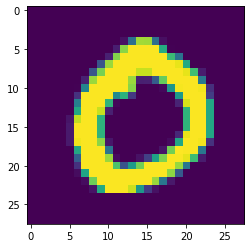

In [7]:
plt.imshow(train_x[25])
print(train_x[25].shape)

In [0]:
def sigmoid(x):
  return 1/(1+np.exp(-x))
def softmax(x):
  a=x-np.max(x,axis=1,keepdims=True)
  s=np.exp(a)
  return s/s.sum(axis=1, keepdims=True)
def sigmoid_derivative(s):
  return s*(1-s)
def tanh(s):
  return -1+2/(1+np.exp(-2*s))
def tanh_derivative( s):
  return 1-s*s
def relu( s):
  s[s<0]=0
  return s
def relu_derivative( s):
  s[s>0]=1
  return s

class Neural_Network_Layer(object): #single layer of neural network
  def __init__(self,i_dim,o_dim,activation='sig'):

    self.initialize(i_dim,o_dim)

    self.activation=activation

  def initialize(self,i_dim,o_dim): #iniitialize data of the layer
    self.w=np.random.randn(i_dim+1,o_dim)*1e-1

    self.dw=np.zeros(self.w.shape) # differential to be added to w

    self.m=np.zeros(self.w.shape)  # momentum factor in adam update

    self.s=np.zeros(self.w.shape) # learning rate factor in adam update

  def feedforward(self,x): # feed forward input of the layer to output
    z=np.dot(np.c_[x,np.ones(len(x))],self.w)
    #print(x.shape)
    #print(z.shape)
    if(self.activation=='sig'):
      self.output=sigmoid(z)
    if(self.activation=='tanh'):
      self.output=tanh(z)
    if(self.activation=='relu'):
      self.output=relu(z)
    if(self.activation=='soft'):
      self.output=softmax(z)
    return self.output

  def derivative(self,z): # return derivative of the layer's output
    if(self.activation=='sig'):
      return sigmoid_derivative(z)
    if(self.activation=='tanh'):
      return tanh_derivative(z)
    if(self.activation=='relu'):
      return relu_derivative(z)

  def compute_grad(self,x,loss_grad): # compute gradient using loss_grad of next and return loss_grad for previeous layer
    if(self.activation=='soft'):
      loss_grad_x=np.einsum('ij,kj->ik',loss_grad,self.w[:-1])
      self.dw=np.einsum('ij,ik->kj',loss_grad,np.c_[x, np.ones(len(x))])/len(x)
    else:
      l_jacobian_w=np.einsum('ij,ik->ikj',self.derivative(self.output),np.c_[x, np.ones(len(x))])
      self.dw=np.einsum('ki,kji->ji',loss_grad,l_jacobian_w)/len(x)
      l_jacobian_input=np.einsum('ij,kj->kij', self.w[:-1],self.derivative(self.output))
      loss_grad_x=np.einsum('ij,ikj->ik',loss_grad,l_jacobian_input)
    return loss_grad_x

  def perturb_weight(self,ep): # 
    self.w=self.w+ep

  def update_mom(self,b):   
    self.m=b*self.m+(1-b)*self.dw
    
  def update_lr(self,b):
    self.s=b*self.s+(1-b)*np.square(self.dw)
  
  def update_weights(self,lr,b1=0.9,b2=0.9):
    self.update_mom(b1)
    self.update_lr(b2)
    self.w=self.w-lr*self.m/(np.sqrt(self.s)+1e-8)

class ConvLayer:
  def __init__(self,in_ch=1,out_ch=1,kernel=(2,2),stride=1):
    self.filters=np.random.randn(out_ch,in_ch,kernel[0],kernel[1])
    self.stride=stride

    self.df=np.zeros(self.filters.shape) # differential to be added to w

    self.m=np.zeros(self.filters.shape)  # momentum factor in adam update

    self.s=np.zeros(self.filters.shape) # learning rate factor in adam update

  def feedforward(self,x):
    if(x.shape[1]!=self.filters.shape[1]):
      print(x.shape[1])
      print(self.filters.shape[1])
      raise Exception("channels in input and output are not same")
    self.out=strided_convolution3D(x,self.filters,self.stride)
    return self.out
  def grad(self,x,loss_grad):
    self.df=strided_convolution3D_grad1(x,loss_grad,1).sum(axis=0)/loss_grad.shape[0]
    gg=np.rot90(loss_grad,2,axes=(2,3))
    p=self.filters.shape[3]-1
    gg1=np.pad(gg, ((0, 0),(0, 0),(p, p),(p,p)), 'constant', constant_values=(0))
    ooo=strided_convolution3D1_g(gg1,self.filters,1)
    return np.rot90(ooo,2,axes=(3,4)).sum(axis=1)

  def perturb_f(self,ep):
    self.filters=self.filters+ep

  def update_mom(self,b):   
    self.m=b*self.m+(1-b)*self.df
    
  def update_lr(self,b):
    self.s=b*self.s+(1-b)*np.square(self.df)
  
  def update_weights(self,lr,b1=0.9,b2=0.9):
    self.update_mom(b1)
    self.update_lr(b2)
    self.filters=self.filters-lr*self.m/(np.sqrt(self.s)+1e-8)


class Max_Pool_Layer:
  def __init__(self,stride):
    self.stride=stride
  def feedforward(self,x):
    self.m_indices=mx_pool(x,self.stride)
    self.m=x.flatten()[self.m_indices].reshape(-1,x.shape[1],
                                               int(x.shape[2]/self.stride),int(x.shape[3]/self.stride))
    return self.m
  def grad(self,x,grad_loss):
    grad_zeros=np.zeros(x.shape[0]*x.shape[1]*x.shape[2]*x.shape[3])
    grad_zeros[self.m_indices]=grad_loss.flatten()
    gg=grad_zeros.reshape(x.shape)
    return gg


class Neural_Network(object):
  def __init__(self,layers=[2,3,1],activation='sig',classes=4): #initialize layers and activation function of layers
    self.classes=classes
    self.layers=[]
    self.no_of_layers=len(layers)-1
    for i in range(self.no_of_layers):
      if(i==(self.no_of_layers-1)):
        self.classes=layers[i+1]
        if(self.classes==1):
          self.layers.append(Neural_Network_Layer(layers[i],layers[i+1]))  
        else:
          self.layers.append(Neural_Network_Layer(layers[i],layers[i+1],'soft'))
      else:        
        self.layers.append(Neural_Network_Layer(layers[i],layers[i+1],activation))
    for layer in self.layers:
      print(layer.w.shape)

  def feedforward(self,x):
    for i in range(self.no_of_layers):
      if(i==0):
        self.layers[i].feedforward(x)
      else:
        self.layers[i].feedforward(self.layers[i-1].output)
    return self.layers[self.no_of_layers-1].output
  
  def grad(self,x,loss_grad):
    grad=loss_grad
    for i in range(self.no_of_layers,0,-1):
      if((i-1)==0):
        grad=self.layers[0].compute_grad(x,grad)
      else:
        grad=self.layers[i-1].compute_grad(self.layers[i-2].output,grad)

    return grad
  
  
  def update_weights(self,lr,b1=0.9,b2=0.9):
    for layer in self.layers: #for each layer update weights
      layer.update_weights(lr,b1,b2)

  def loss(self,y,yhat): # return loss depending upon type of classification
    if(self.classes==1):
      return self.crossentropy(y,yhat)
    else:
      return self.MCE(y,yhat)

  def loss_grad(self,y,yhat):
    if(self.classes==1):
      return self.binary_loss_grad(y,yhat).T
    else:
      return self.MCE_grad(y,yhat)
  
  def MCE_grad(self,y,yhat):
    return yhat-np.eye(self.classes)[y]

  def MCE(self, Y, Y_pred):
    return -np.sum(np.log(Y_pred[np.eye(self.classes,dtype='bool')[Y]]))/len(Y) 

  def binary_loss_grad(self,y,yhat):
    return -y/yhat.T+(1-y)/(1-yhat.T)

  def grad_check_input(self,x,y,grad_desired,in_dim): # check gradient w.r.t input using numerical gradient method
    n=in_dim
    grad=np.zeros(grad_desired.shape)
    ep=np.eye(n,n)*1e-5
    for i in range(n):
      y1=self.feedforward(x+ep[i])
      y2=self.feedforward(x-ep[i])
      der=self.loss(y,y1)-self.loss(y,y2) 
      grad[i]=der/2e-5
    print(grad)
    return np.linalg.norm(grad-grad_desired)

  def grad_check_weights(self,x,y,layer):
      #print(self.layers[layer].w)
      dw=np.zeros((self.layers[layer].w.shape[0],self.layers[layer].w.shape[1]))
      for i in range(self.layers[layer].w.shape[0]):
        for j in range(self.layers[layer].w.shape[1]):
          ep=np.zeros(self.layers[layer].w.shape)
          ep[i,j]=1e-5
          self.layers[layer].perturb_weight(ep)
          y1=self.feedforward(x)
          self.layers[layer].perturb_weight(-2*ep)
          y2=self.feedforward(x)
          der=self.loss(y,y1)-self.loss(y,y2) 
          self.layers[layer].perturb_weight(ep)
          dw[i,j]=der/2e-5
      print(dw)
      return np.linalg.norm(dw-self.layers[layer].dw)

  def crossentropy(self, y, y_hat):
    loss=-np.sum(y*np.log(y_hat.T)+(1-y)*np.log(1-y_hat.T))/len(y) 
    return loss

class Network:
  def __init__(self):
    self.n=28
    self.in_ch=1
    self.m=10
    self.f1=7
    self.f2=5
    self.cs=1
    self.o_ch=5

    o2ch=5

    self.mxs=2

    self.conv1=ConvLayer(in_ch=self.in_ch,out_ch=self.o_ch,kernel=(self.f1,self.f1),stride=self.cs)

    self.conv2=ConvLayer(in_ch=self.o_ch,out_ch=o2ch,kernel=(self.f2,self.f2),stride=self.cs)

    self.mxp1=Max_Pool_Layer(self.mxs)

    cos=(self.n-self.f1+1)//self.mxs-self.f2+1


    self.FC1=Neural_Network([o2ch*cos*cos,4,1],activation='sig')

  def gen_images(self):
    return np.random.randn(self.m,self.in_ch,self.n,self.n)

  def update_weights(self,lr,b1=0.9,b2=0.9):
    self.conv1.update_weights(lr,b1=0.9,b2=0.9)
    self.conv2.update_weights(lr,b1=0.9,b2=0.9)
    self.FC1.update_weights(lr,b1=0.9,b2=0.9)

  def feedforward(self,x):
    c1=self.conv1.feedforward(x)
    m1=self.mxp1.feedforward(c1)
    c2=self.conv2.feedforward(m1)
    f1=self.FC1.feedforward(c2.reshape(c2.shape[0],-1))
    return f1
  def grad(self,x,y,yhat):
    loss_grad=self.FC1.loss_grad(y,yhat)
    #loss_grad=2*(yhat-y)
    gradF1=self.FC1.grad(self.conv2.out.reshape(loss_grad.shape[0],-1),loss_grad).reshape(self.conv2.out.shape)
    #print(gradF1.shape)
    #nn.compute_grad(x,loss_grad).sum(axis=0)/2
    gradC2=self.conv2.grad(self.mxp1.m,gradF1)
    #print(gradC2.shape)
    grad_mxp1=self.mxp1.grad(self.conv1.out,gradC2)
    gradC1=self.conv1.grad(x,grad_mxp1)
    #print(gradC1)

  def num_grad(self,x,y):
    ep=np.zeros(x.shape)
    dw=np.zeros(x.shape)
    for dd in range(x.shape[0]):
      for k in range(x.shape[1]):
       for i in range(x.shape[2]):
         for j in range(x.shape[3]):

           ep[dd,k,i,j]=1e-4
           yhat1=self.feedforward(x+ep)
           yhat2=self.feedforward(x-ep)
           #print(yhat1.shape)
           dw[dd,k,i,j]=(self.FC1.loss(y,yhat1)-self.FC1.loss(y,yhat2))/2e-4
           ep[dd,k,i,j]=0

    return dw

  def num_grad_df(self,x,y,shape,func):
    #f=self.conv2.filters
    #func=self.conv2.perturb_f
    ep=np.zeros(shape)
    dw=np.zeros(shape)
    #print(self.conv2.filters)
    for dd in range(shape[0]):
      for k in range(shape[1]):
       for i in range(shape[2]):
         for j in range(shape[3]):

           ep[dd,k,i,j]=1e-4
           func(ep)
           #print(self.conv2.filters)
           yhat1=self.feedforward(x)
           func(-2*ep)
           yhat2=self.feedforward(x)
           #print(self.conv2.filters)
           func(ep)
           #print(yhat1.shape)
           dw[dd,k,i,j]=(self.FC1.loss(y,yhat1)-self.FC1.loss(y,yhat2))/2e-4
           ep[dd,k,i,j]=0

    return dw

In [0]:
np.random.seed(100000)
nn=Network()
img=nn.gen_images()
y=(np.random.randn(img.shape[0])>0)/1
yhat=nn.feedforward(img)
nn.grad(img,y,yhat)
loss_grad=nn.FC1.loss_grad(y,yhat)
#loss_grad_x=np.einsum('ij,kj->ik',loss_grad,self.w[:-1])
x1=nn.FC1.layers[0].output

dw=np.einsum('ij,ik->kj',loss_grad,np.c_[x1, np.ones(len(x1))])/len(x1)
print(dw)
print(x1.shape)
print(loss_grad.shape)

(5, 4)
(5, 1)
[[0.23712643]
 [0.26059866]
 [0.16315606]
 [0.02279548]
 [0.27899397]]
(10, 4)
(10, 1)


In [0]:
nn.FC1.grad_check_weights(x1,y,1)

[[0.03952345]
 [0.03625335]
 [0.04442898]
 [0.05198391]
 [0.09027377]]


0.061569217724248365

In [0]:
nn.FC1.grad_check_weights(nn.conv2.out.reshape(nn.conv2.out.shape[0],-1),y,1)

[[0.05895717]
 [0.06479381]
 [0.04055392]
 [0.00566151]
 [0.06935103]]


1.495286466298657e-11

In [0]:
yhat=nn.feedforward(img)
nn.grad(img,y,yhat)
nn.FC1.layers[0].dw

array([[-0.00812571, -0.00801027, -0.00533791, -0.00229384],
       [-0.01198913, -0.01529798, -0.00604126, -0.00332642],
       [-0.00787798, -0.01071905, -0.00333557,  0.00130948],
       [-0.00159403, -0.00210315,  0.00064619,  0.00557509],
       [ 0.00287991,  0.00348557,  0.00158188,  0.00076234]])

In [0]:
#np.random.seed(10000)
np.random.seed(100000)
nn=Network()
img=nn.gen_images()
y=(np.random.randn(img.shape[0])>0)/1
yhat=nn.feedforward(img)

nn.grad(img,y,yhat)
#nn.num_grad(img,y)
#print(nn.conv1.df)
#print(nn.num_grad_df(img,y,nn.conv1.filters.shape,nn.conv1.perturb_f))
#print(nn.conv1.df/img.shape[0])
#print(nn.num_grad_df(img,y,nn.conv1.filters.shape,nn.conv1.perturb_f))
epochs=3
l=nn.FC1.loss(y,yhat)
for epoch in range(epochs):
  yhat=nn.feedforward(img)
  nn.grad(img,y,yhat)
  nn.update_weights(1e-1)
  if(epoch%(epochs/10)==1):
    print(nn.FC1.loss(y,yhat))
print(nn.conv1.df)

(99, 4)
(5, 1)
[[[[-5.11355630e-11  3.68826920e-10  2.07596240e-11  2.54010560e-10
     6.31989463e-12  2.57463964e-10 -2.02354794e-10]
   [ 3.55838993e-10 -3.83039238e-10 -4.59458484e-10 -5.91663053e-11
     5.85848277e-10 -6.00659274e-11 -2.79101750e-10]
   [ 9.63982070e-11 -1.28369084e-11  3.10407574e-11  4.03344596e-10
     4.06055820e-10 -4.13123860e-12  4.60221868e-11]
   [ 2.75674168e-11 -1.66148494e-10 -1.82285987e-10 -4.13095390e-10
     1.25644216e-10  8.90532355e-11 -1.84056126e-10]
   [-3.28156949e-10  1.99903211e-10  1.89254545e-10  7.23617192e-11
    -1.26367473e-10  8.91762270e-11  2.18930829e-10]
   [ 5.08697266e-11  2.38622896e-10 -2.09405526e-10  1.49479253e-10
     2.05991482e-10 -1.91687854e-10  5.15410058e-12]
   [-7.87068694e-11  1.89594009e-10 -1.44494681e-11 -1.94746823e-11
     1.36676242e-10  4.10192910e-10 -1.07466814e-10]]]


 [[[ 1.34317840e-10  9.29748964e-11  1.85180426e-10 -1.25747909e-10
    -4.95475310e-10 -1.42321241e-10 -5.90439099e-10]
   [-2.526640

In [0]:
yhat=nn.feedforward(img)
nn.grad(img,y,yhat)
print(nn.conv2.df)
print(nn.num_grad_df(img,y,nn.conv2.filters.shape,nn.conv2.perturb_f))

[[[[-0.00846531 -0.00985575]
   [-0.01211816  0.00315272]]]]
[[[[-0.00846531 -0.00985575]
   [-0.01211816  0.00315272]]]]


In [0]:
nn.FC1.layers[0].w.shape

(5, 4)

In [0]:
XX=train_x[:1000]
XX=np.vstack([XX,train_x[10000:11000]])

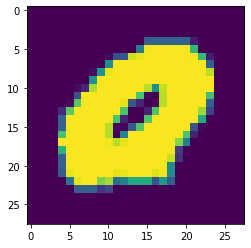

In [0]:
plt.imshow(XX[999])

In [0]:
YY=train_y[:1000]
YY=np.vstack([YY,train_y[10000:11000]]).flatten()

1


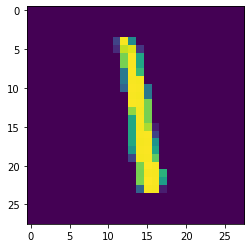

In [0]:
plt.imshow(XX[1000])
print(YY[1000])

In [0]:
YY.shape

(2000,)

In [0]:
nn=Network()
img=XX[:,np.newaxis,:,:]
y=YY
yhat=nn.feedforward(img)
print(yhat.shape)

(5, 4)
(5, 1)


ValueError: ignored

In [0]:
yhat=nn.feedforward(img)
print(yhat.shape)

(2000, 2000)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [0]:
nn.grad(img,y,yhat)

In [0]:
nn.update_weights(1e-1)

In [0]:
nn.conv2.filters.shape

(5, 5, 5, 5)

In [0]:
#np.random.seed(10000)
nn=Network()
#img=nn.gen_images()
img=XX[:,np.newaxis,:,:]
#y=np.random.randint(2,size=img.shape[0]).reshape(img.shape[0],1)
y=YY
yhat=nn.feedforward(img)
print(yhat.shape)
#nn.grad(img,y,yhat)
#nn.num_grad(img,y)
#print(nn.conv1.df/img.shape[0])
#print(nn.num_grad_df(img,y,nn.conv1.filters.shape,nn.conv1.perturb_f))
epochs=1000
l=nn.FC1.loss(y,yhat)
for epoch in range(epochs):
  yhat=nn.feedforward(img)
  nn.grad(img,y,yhat)
  nn.update_weights(1e-1)
  if(epoch%(epochs/10)==1):
    print(nn.FC1.loss(y,yhat))
#print(nn.conv1.df/img.shape[0])

(246, 4)
(5, 1)
(2000, 1)
0.6523515777322453


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


KeyboardInterrupt: ignored

In [0]:
yhat=nn.feedforward(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [0]:
yhat.shape

(2000, 1)

In [0]:
ind=np.argmax(yhat>0.5)

In [0]:
ind=yhat>0.5
ddd=ind-y.reshape(-1,1)

In [0]:
np.sum(ddd)

1